# Analyze CSV data files with Vanna

world top companies
- https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide

## Setup

In [1]:
from glob import glob
import os
import re
from time import time
from datetime import datetime 

import pandas as pd
import sqlite3

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

In [2]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

### load SQLite db with CSV data

In [3]:
file_db_path = "../data/company_rank.sqlite"
file_db = os.path.abspath(os.path.expanduser(file_db_path))
print(file_db)

/home/papagame/projects/wgong/py4kids/lesson-18-ai/vanna/note_book/data/company_rank.sqlite


In [4]:
LOAD_CSV = True # False
if LOAD_CSV:
    csv_files = glob("../data/company_rank/*.csv")
    print(csv_files)
    
    conn = sqlite3.connect(file_db)
    df_dict = {}
    col_map = {}
    for i in csv_files:
        t = i.split("/")[-1].lower().replace("companies_ranked_by_","").replace(".csv","")
        df = pd.read_csv(i)
        c_map = {c:c.lower() for c in df.columns}
        c_map['price (GBP)'] = 'price_gbp'
        # print(f"col_map: {c_map}")
        table_name = f"t_{t}"
        print(f"Load '{i}' into table_name: '{table_name}'")
        col_map[table_name] = c_map
        df.rename(columns=c_map, inplace=True)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        df_dict[table_name] = df
    conn.close()

['../data/company_rank/Companies_ranked_by_Market_Cap.csv', '../data/company_rank/Companies_ranked_by_P_E_ratio.csv', '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv', '../data/company_rank/Companies_ranked_by_Earnings.csv', '../data/company_rank/country_region.csv', '../data/company_rank/Companies_ranked_by_Revenue.csv']
Load '../data/company_rank/Companies_ranked_by_Market_Cap.csv' into table_name: 't_market_cap'
Load '../data/company_rank/Companies_ranked_by_P_E_ratio.csv' into table_name: 't_p_e_ratio'
Load '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv' into table_name: 't_dividend_yield'
Load '../data/company_rank/Companies_ranked_by_Earnings.csv' into table_name: 't_earnings'
Load '../data/company_rank/country_region.csv' into table_name: 't_country_region'
Load '../data/company_rank/Companies_ranked_by_Revenue.csv' into table_name: 't_revenue'


In [5]:
# verify
VERIFY_DB = True # False # 
if VERIFY_DB:
    conn = sqlite3.connect(file_db)
    sql_stmt = f"select name from {table_name} limit 10"
    sql_stmt = """ 
    select country from t_revenue
     UNION 
    select country from t_earnings
     UNION 
    select country from t_market_cap
     UNION 
    select country from t_p_e_ratio
     UNION 
    select country from t_dividend_yield
    """
    df_2 = pd.read_sql_query(sql_stmt, conn).fillna("")
    country_list = df_2["country"].to_list()
    # print(df_2)
    conn.close()

In [6]:
country_list

['',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'British Virgin Islands',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Malaysia',
 'Malta',
 'Mexico',
 'Monaco',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay'

### Fix country

### Setup LLM

In [7]:
model_name = 'deepseek-coder-v2'
config = {
    'model': model_name,   # 'mistral' # "starcoder2"
}

clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [8]:
vn = MyVanna(config=config)

In [9]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [10]:
# file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [11]:
vn.run_sql_is_set

True

In [12]:
if clean_and_train:
    vn.remove_collections()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [13]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [14]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,..."
1,table,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\..."
2,table,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE..."
3,table,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n..."
4,table,"CREATE TABLE ""t_country_region"" (\n""country"" T..."
5,table,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ..."


In [15]:
business_docs = """
Introduction:
This dataset ranks top companies in the world.
Its analysis delves into the financial performance of top companies by examining key metrics such as revenue, earnings, market capitalisation, P/E ratio, and dividend yield. By comparing these metrics, we gain a comprehensive understanding of a company's scale, profitability, market value, and growth potential. Through visualisations, the analysis also explores correlations between these metrics and offers insights into country-level performance, highlighting economic dominance across various sectors. This holistic approach provides a multi-dimensional view of global financial powerhouses, investor confidence, and regional economic trends.

Key Metrics Used:
1. Revenue (Trailing Twelve Months - TTM):
Table Name: t_revenue ;
Definition: This is the total income generated by a company from its operations in the last twelve months ;
Potential Insights: High revenue often indicates market dominance or high sales volume. Comparing revenues can reveal which companies are the largest in terms of business volume.

2. Earnings (TTM):
Table Name: t_earnings
Definition: This refers to the company's profit after taxes and expenses over the trailing twelve months.
Potential Insights: Companies with high earnings are more efficient at converting revenue into profit, suggesting better profitability or cost management. A comparison of earnings provides insight into profitability rather than just scale.

3. Market Capitalisation (Market Cap):
Table Name: t_market_cap
Definition: Market cap is the total value of a company's outstanding shares of stock, calculated as stock price multiplied by the number of shares. It indicates the company’s size in the stock market.
Potential Insights: High market cap usually indicates investor confidence in the company. Comparing market cap among the top 15 companies reveals their relative size in financial markets.

4. P/E Ratio (TTM):
Table Name: t_p_e_ratio
Definition: Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings.
Potential Insights: A high P/E ratio may indicate that investors expect high growth in the future, while a low P/E ratio could imply undervaluation or scepticism about growth. Companies are compared by their growth prospects or current valuation.

5. Dividend Yield (TTM):
Table Name: t_dividend_yield
Definition: Dividend yield is a financial ratio that shows how much a company pays out in dividends each year relative to its share price.
Potential Insights: High dividend yield may indicate that a company returns more income to shareholders. It’s particularly useful for income-focused investors.

6. Country-Region Map:
Table Name: t_country_region
Definition: This table translate country to region
"""

In [16]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    # vn.train(documentation="In the chinook database invoice means order")
    vn.train(documentation=business_docs)


Adding ddl: CREATE TABLE "t_market_cap" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "marketcap" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_p_e_ratio" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "pe_ratio_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_dividend_yield" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "dividend_yield_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_earnings" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "earnings_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_country_region" (
"country" TEXT,
  "code_2" TEXT,
  "code_3" TEXT,
  "region" TEXT,
  "sub_region" TEXT,
  "country_name" TEXT
)
Adding ddl: CREATE TABLE "t_revenue" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "revenue_ttm" INTEGER,
  "price_gbp" REAL,
  "country" TEXT
)
Adding documentation....


In [17]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,74d9b967-92cf-523f-9a8b-05d416dac17a-ddl,None,"CREATE TABLE ""t_country_region"" (\n""country"" T...",ddl
1,75de6b21-b3df-53ea-a36f-9af69e40913b-ddl,None,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ...",ddl
2,87669f00-5543-579a-a95c-fec096be48ed-ddl,None,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE...",ddl
3,b94bb579-73d6-521b-86de-5d5e599bbde5-ddl,None,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,...",ddl
4,e0a92066-0804-52fd-be4e-437ac10622de-ddl,None,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n...",ddl
5,f68c7d4a-806f-55f0-962d-74de7018e372-ddl,None,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\...",ddl
0,9417193f-bdbb-52c5-a0db-47614793af98-doc,None,\nIntroduction:\nThis dataset ranks top compan...,documentation


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

In [18]:
ts_start = time()

```sql
SELECT name FROM sqlite_master WHERE type = 'table';
```


In [19]:
sql_id = 1

questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores Company P/E Ratio",
    "which table stores Company Dividend Yield",
    "which table stores Company Market Cap",
    "which table stores Company Revenue",
    "which table stores Company Earnings",
    "Find the customer with the most invoices ",
    "Find top 5 companyies with the lowest PE Ratio",   
    "Find top 10 companyies in the United States with the heighest market cap",   
]

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 2:  Can you list all tables in the SQLite database catalog?


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "code_2" TEX

SELECT name FROM sqlite_master WHERE type='table'


[( <DataFrame> )]
queried dataframe


,name
0,t_market_cap
1,t_p_e_ratio
2,t_dividend_yield
3,t_earnings
4,t_country_region
5,t_revenue



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame and it contains the table names
df = pd.DataFrame({'name': ['table1', 'table2', 'table3']})  # Example data, replace with actual data

fig = go.Figure(data=[go.Indicator(
    mode="number",
    value=len(df),
    title={"text": "Number of Tables"},
    number={'prefix': ""}
)])

fig.update_layout(title='Tables in SQLite Database')

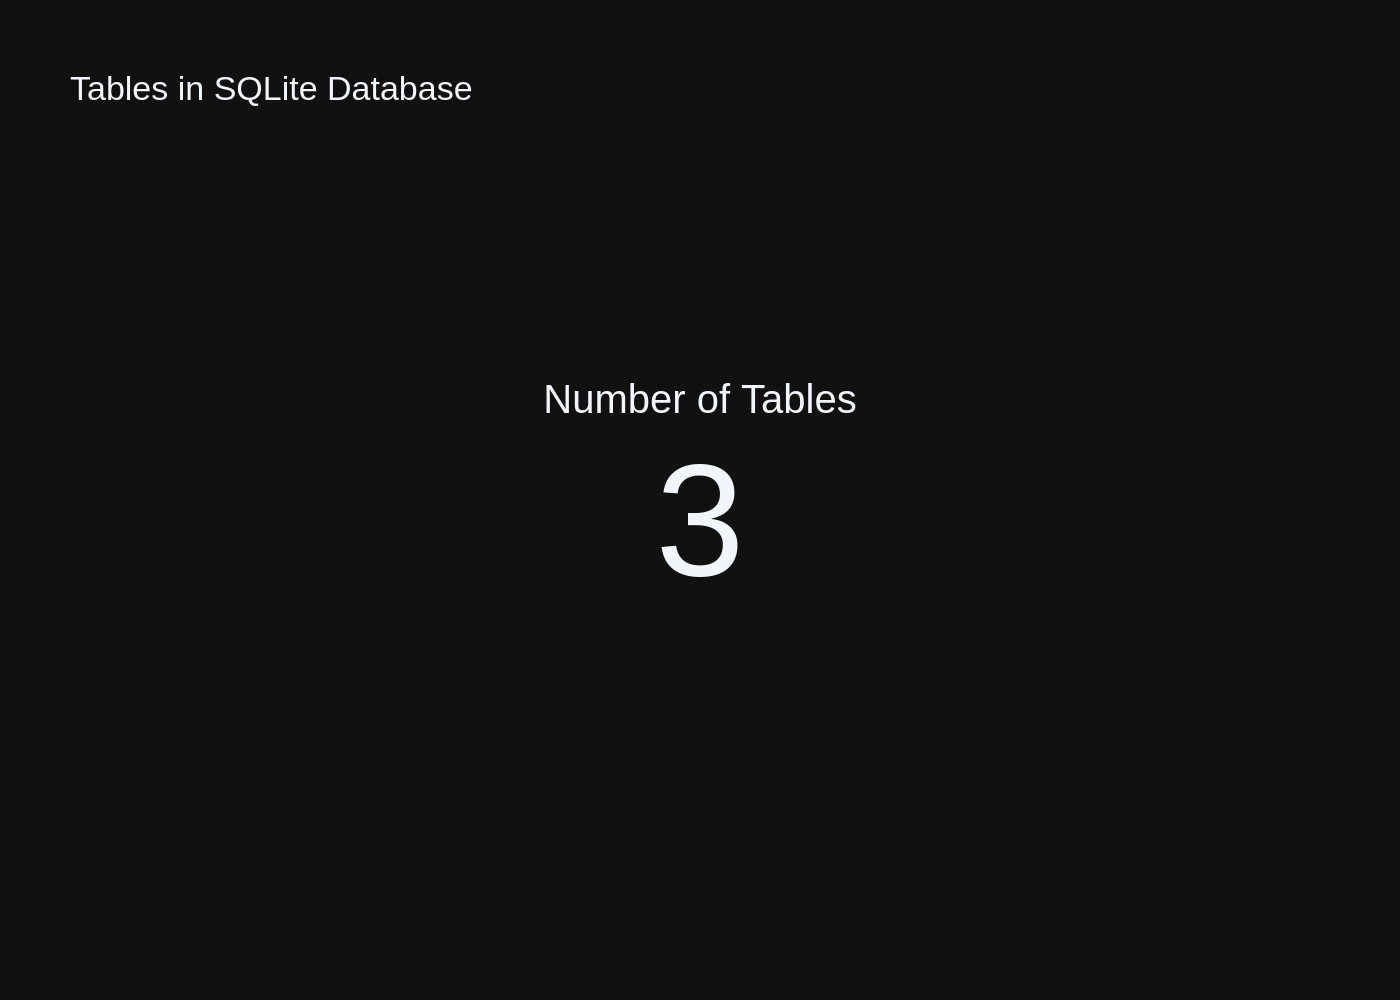

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 3:  which table stores Company P/E Ratio


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\

SELECT "name", "pe_ratio_ttm" FROM t_p_e_ratio


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm
0,Imperial Petroleum,0.109943
1,Vertex Energy,0.188889
2,Spin Master,0.224758
3,Performance Shipping,0.225293
4,TherapeuticsMD,0.340956
...,...,...
9907,MBX Biosciences,0.000000
9908,Bicara Therapeutics,-70.666700
9909,Zensho Holdings,275.203000
9910,BKV Corporation,-12.410500



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is already defined and contains the data
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        number={'prefix': "P/E Ratio: ", 'suffix': ""},
        title={"text": f"Company: {df['name'].values[0]}"}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['pe_ratio_ttm'])])

fig.update_layout(title='Company P/E Ratios')

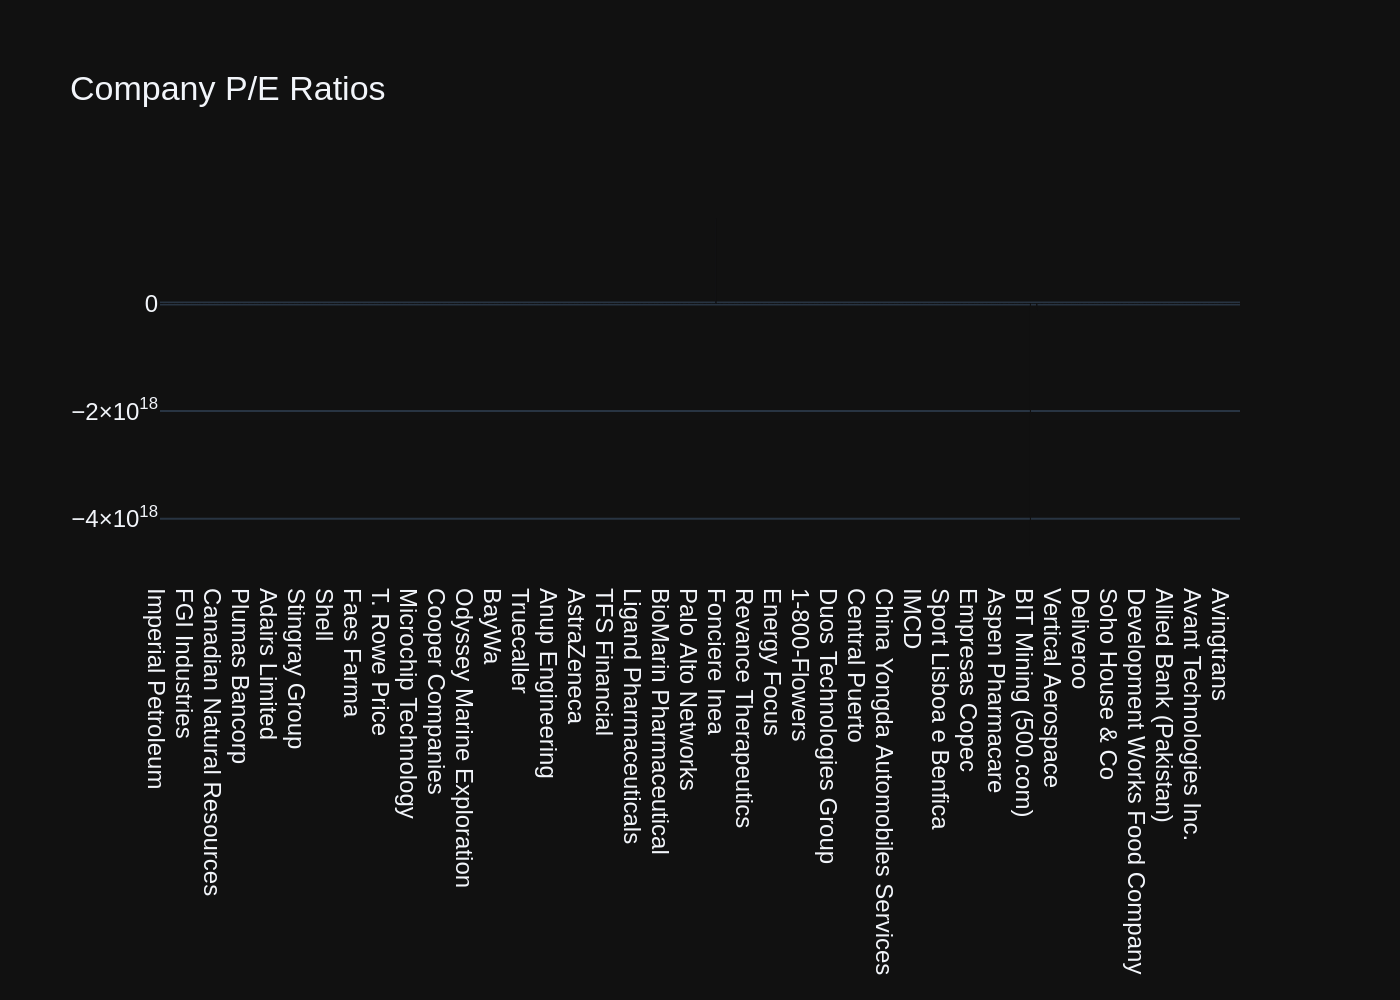

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 4:  which table stores Company Dividend Yield


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "

SELECT "name" FROM t_dividend_yield


[( <DataFrame> )]
queried dataframe


,name
0,LianBio
1,Richter Gedeon
2,Delek Group
3,LMP Automotive Holdings
4,MBIA
...,...
9907,Lite-On Technology
9908,Zensho Holdings
9909,BKV Corporation
9910,BioAge Labs



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame and it contains a single value in the 'name' column
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        number={'value': 1},
        title={"text": "Company Dividend Yield"}
    ))
else:
    # If there are multiple values, you can create a bar chart or another type of plot
    fig = go.Figure(go.Bar(x=df['name'], y=[1]*len(df), marker_color='rgba(55, 128, 191, 0.7)'))

fig.update_layout(title_text="Company Dividend Yields", height=600, width=800)

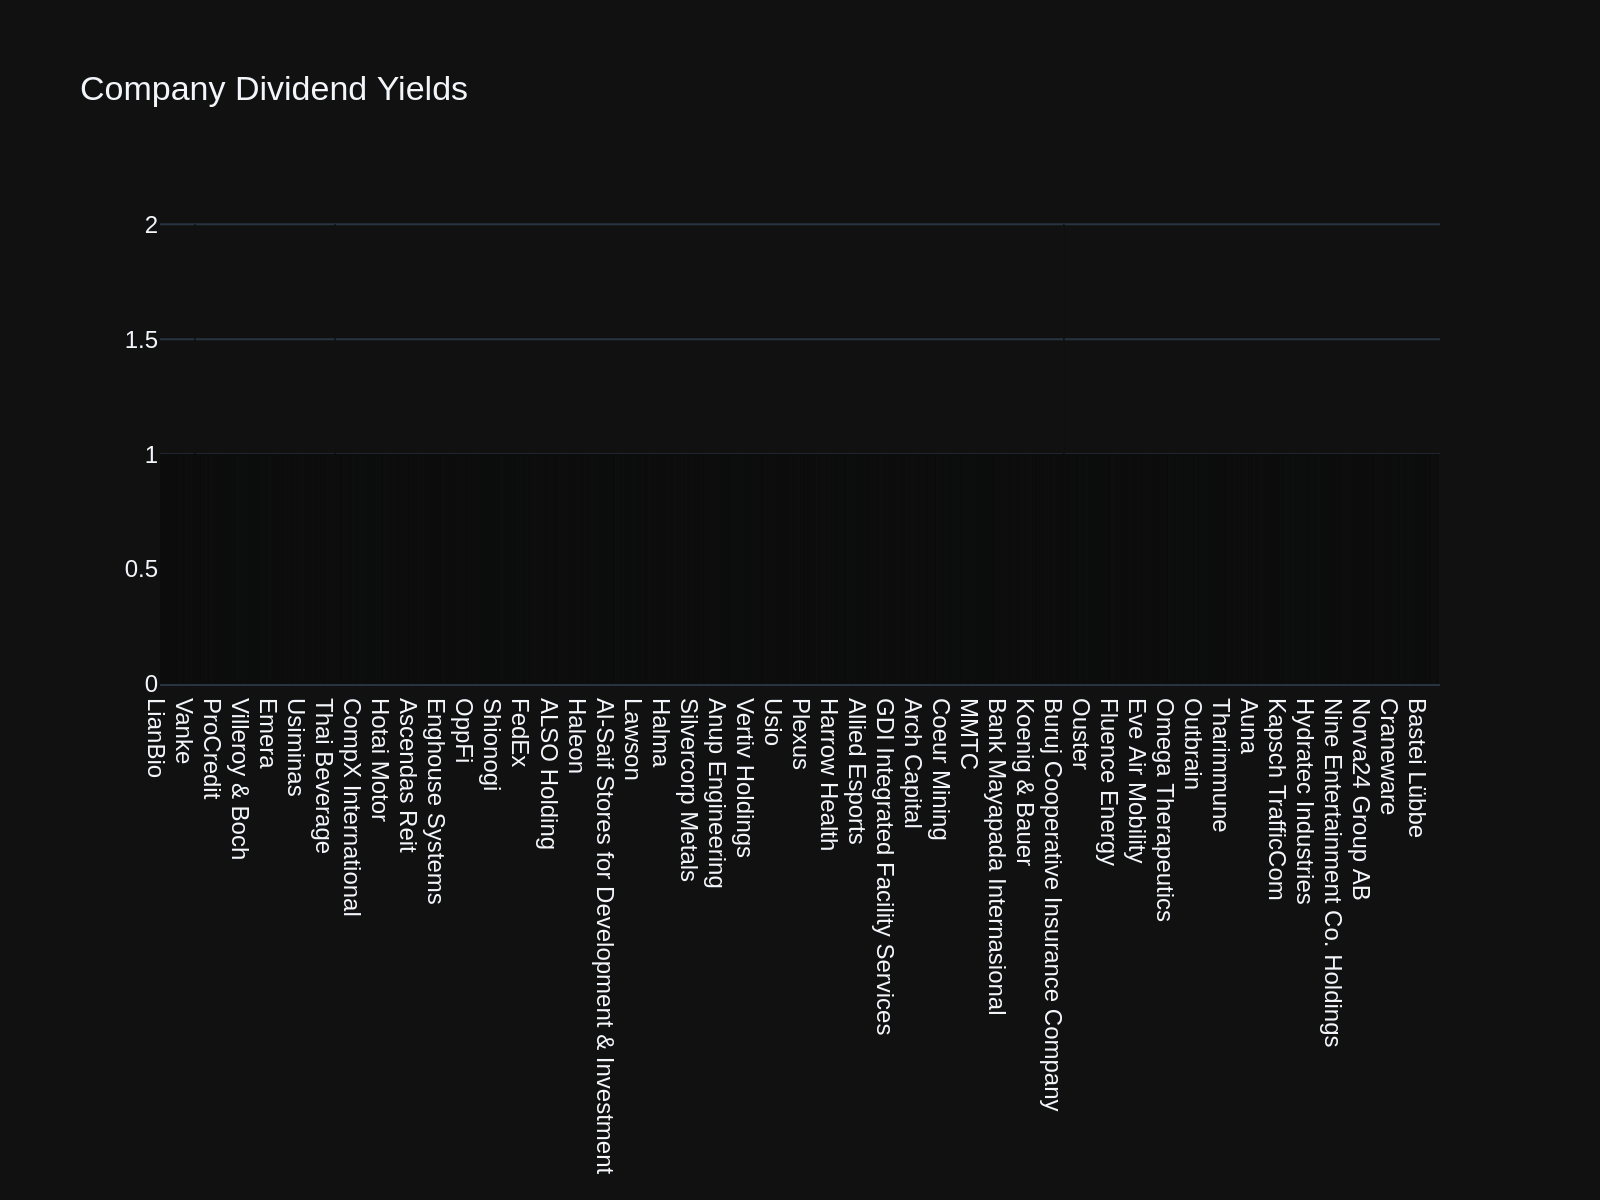

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 5:  which table stores Company Market Cap


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,

SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%market_cap%'


[( <DataFrame> )]
queried dataframe


,name
0,t_market_cap



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=1,
        title={"text": f"{df['name'].iloc[0]}"}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=['Tables with Market Cap'], fill_color='paleturquoise', align='left'),
                                  cells=dict(values=[[i] for i in df['name']], fill_color='lavender', align='left'))])
fig.update_layout(title_text="Company Market Caps")

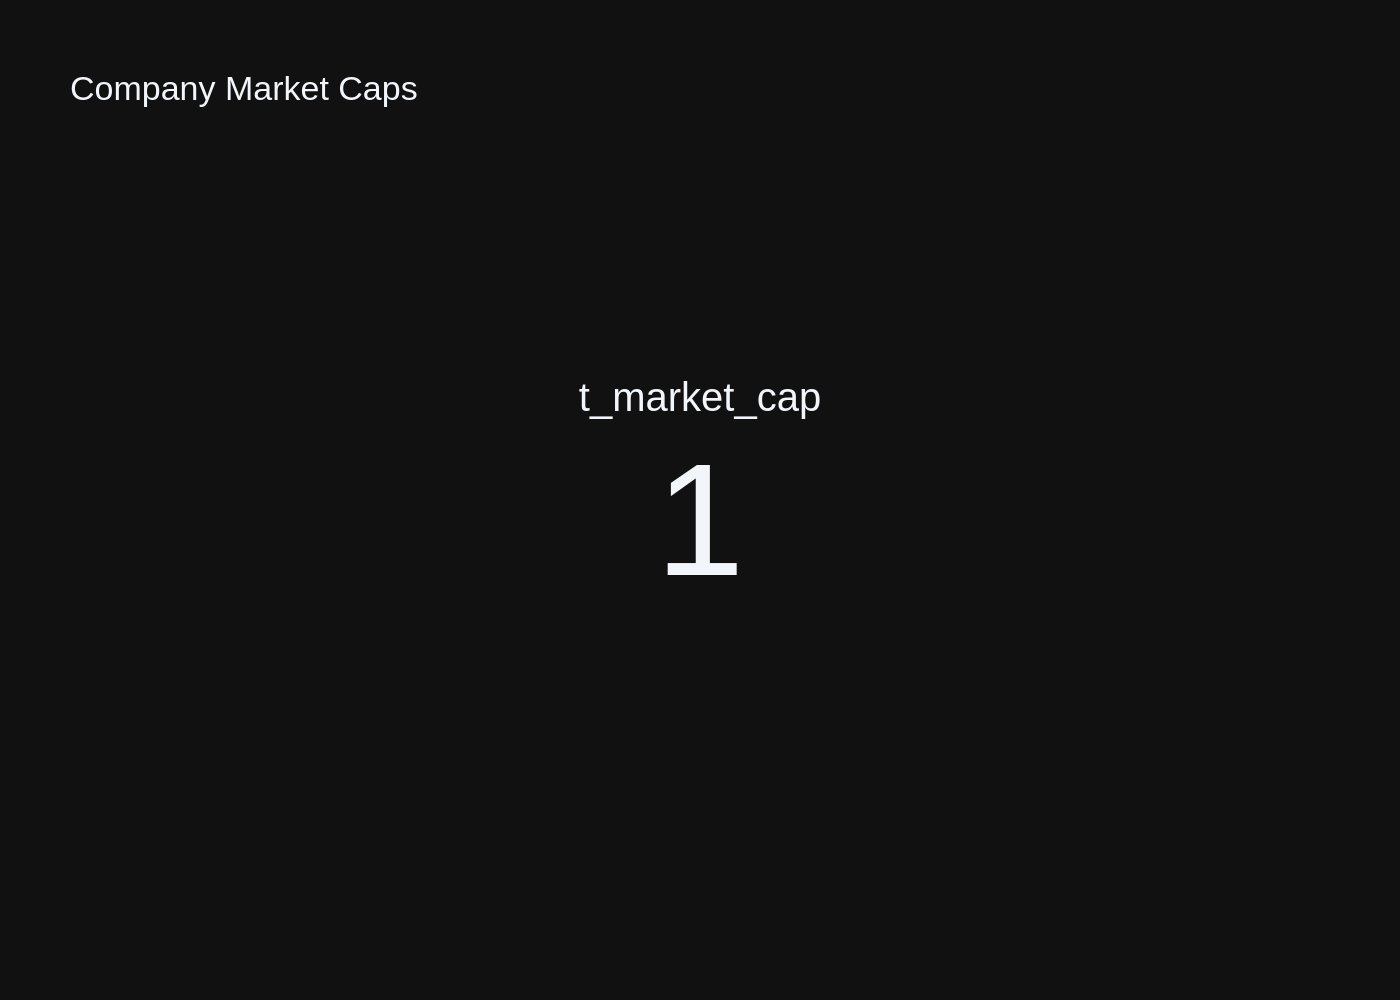

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 6:  which table stores Company Revenue


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n 

SELECT "name" FROM t_revenue


[( <DataFrame> )]
queried dataframe


,name
0,Walmart
1,Amazon
2,Saudi Aramco
3,Sinopec
4,PetroChina
...,...
9907,Kinnevik
9908,Sofina
9909,Quilter
9910,M&G plc



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].values[0],
        title={"text": "Company Revenue"}
    ))
else:
    fig = px.bar(df, x='name', y=None, text_auto='.2s')

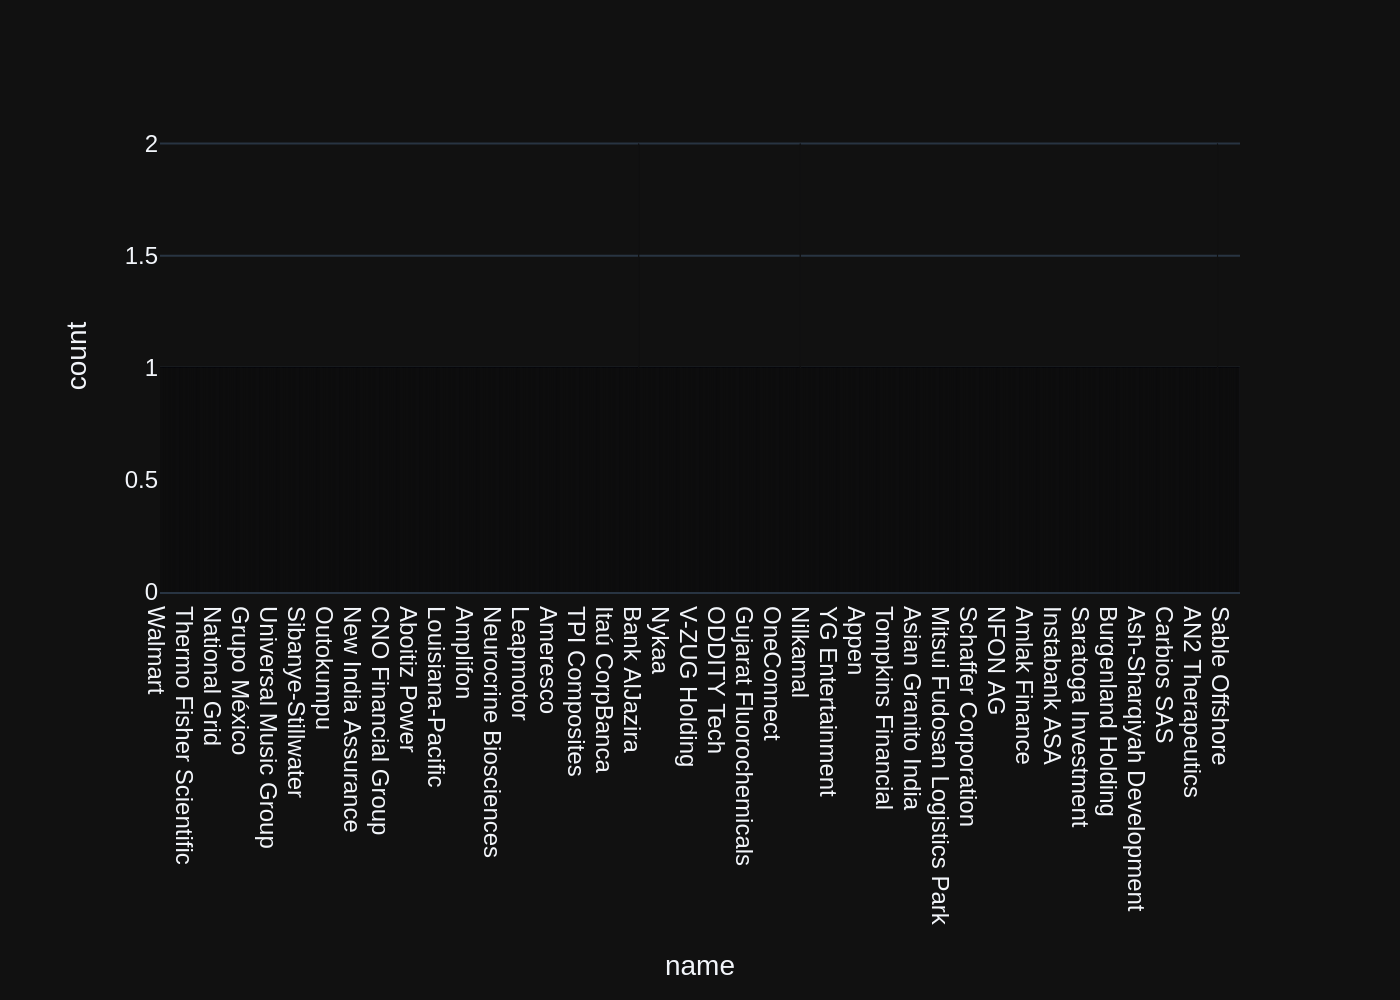

Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 7:  which table stores Company Earnings


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol

SELECT "name" FROM t_earnings


[( <DataFrame> )]
queried dataframe


,name
0,Saudi Aramco
1,Apple
2,Microsoft
3,Alphabet (Google)
4,Berkshire Hathaway
...,...
9907,Vodafone
9908,Warner Bros. Discovery
9909,Walgreens Boots Alliance
9910,Veolia



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Company Earnings"}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=['Company Name']), cells=dict(values=[[name for name in df['name']]]))])

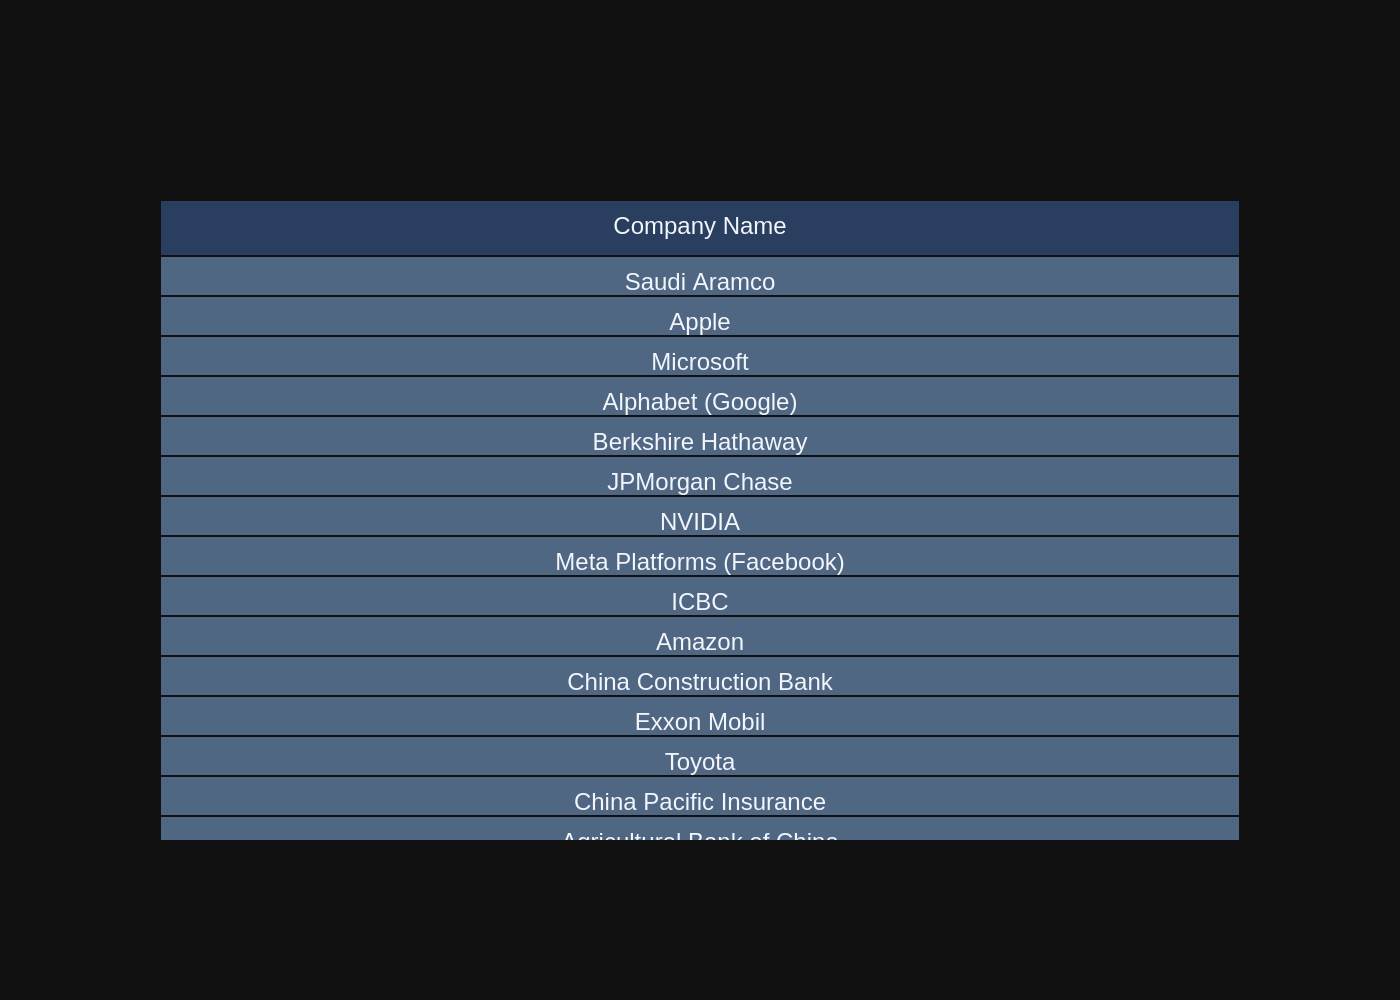

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 8:  Find the customer with the most invoices 


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" T

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "co

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, COUNT(i.InvoiceId) AS InvoiceCount
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY InvoiceCount DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "code_2" TEXT,\n  "code_3" TEXT,\n  "region" TEXT,\n  "sub_region" TEXT,\n  "country_name" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, COUNT(i.InvoiceId) AS InvoiceCount
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY InvoiceCount DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



[( RETRY )]
***** 2 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_country_region" (\n"country" TEXT,\n  "code_2" TEXT,\n  "code_3" TEXT,\n  "region" TEXT,\n  "sub_region" TEXT,\n  "country_name" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "

SELECT c.CustomerId, c.FirstName || ' ' || c.LastName AS CustomerName, COUNT(i.InvoiceId) AS InvoiceCount
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId
ORDER BY InvoiceCount DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 9:  Find top 5 companyies with the lowest PE Ratio


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,

SELECT name FROM t_p_e_ratio ORDER BY pe_ratio_ttm LIMIT 5


[( <DataFrame> )]
queried dataframe


,name
0,Dutch Bros
1,DigitalBridge Group
2,Mezzan Holding Company
3,National Investments Company (Kuwait)
4,Beeks Financial Cloud Group



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import numpy as np

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Top Company with the Lowest PE Ratio"}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=['Company Name']),
                                   cells=dict(values=[[row] for row in df['name']]))])

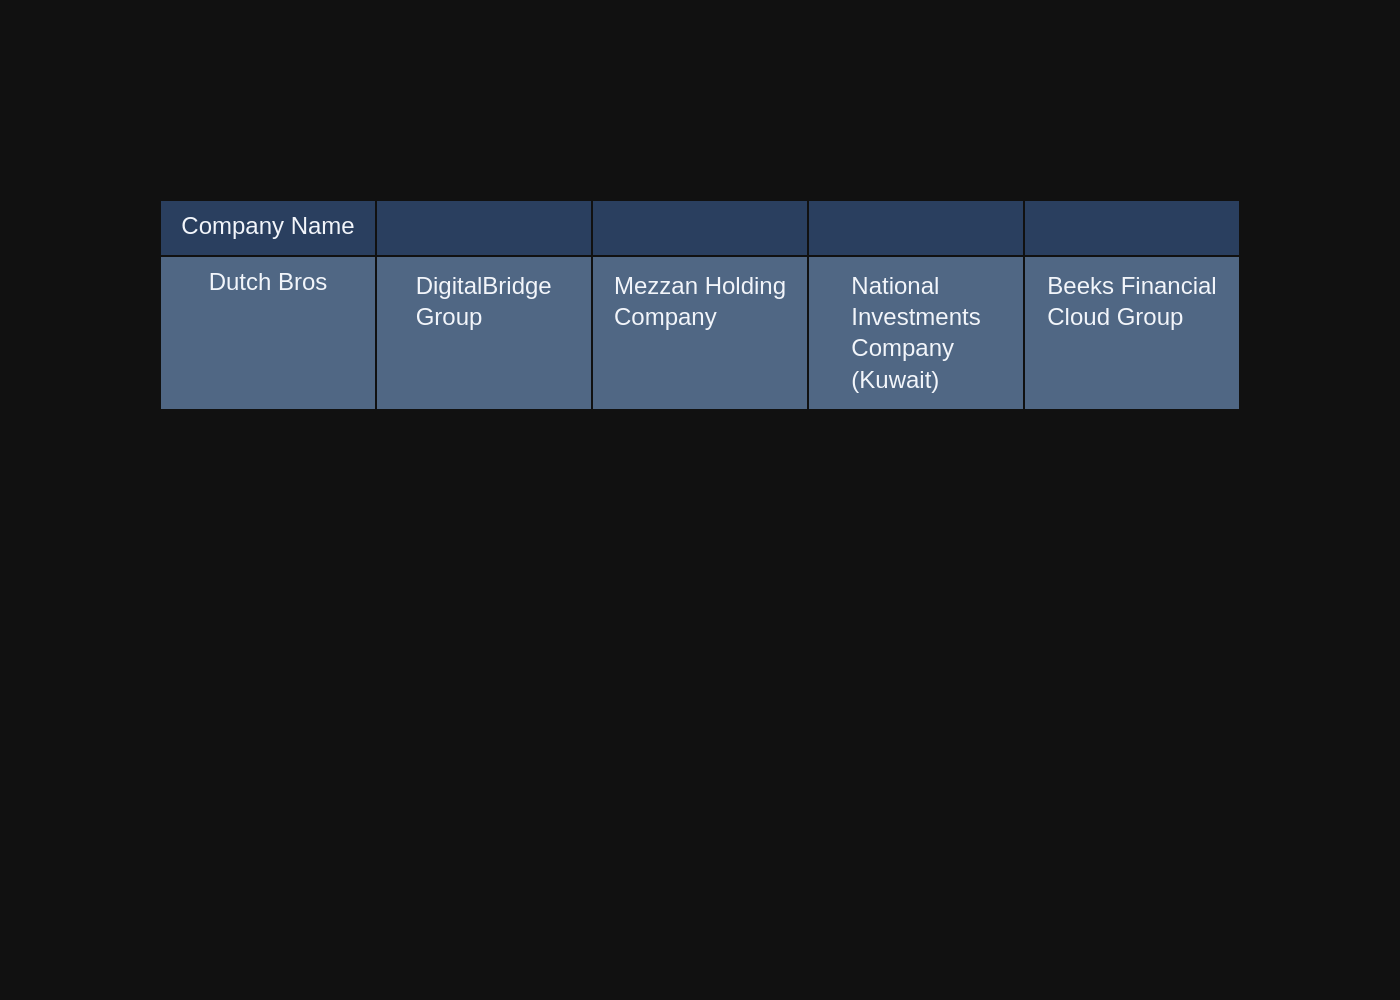

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION - 10:  Find top 10 companyies in the United States with the heighest market cap


[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGE

SELECT name FROM t_market_cap WHERE country = 'United States' ORDER BY marketcap DESC LIMIT 10


[( <DataFrame> )]
queried dataframe


,name
0,Apple
1,Microsoft
2,NVIDIA
3,Alphabet (Google)
4,Amazon
5,Meta Platforms (Facebook)
6,Berkshire Hathaway
7,Tesla
8,Broadcom
9,Eli Lilly



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['marketcap'].values[0],
        title={"text": "Highest Market Cap"},
        number={'prefix': "$"}
    ))
else:
    fig = px.bar(df, x='name', y='marketcap', text_auto='.2s')

fig.update_layout(title="Top 10 Companies in the United States by Market Cap")

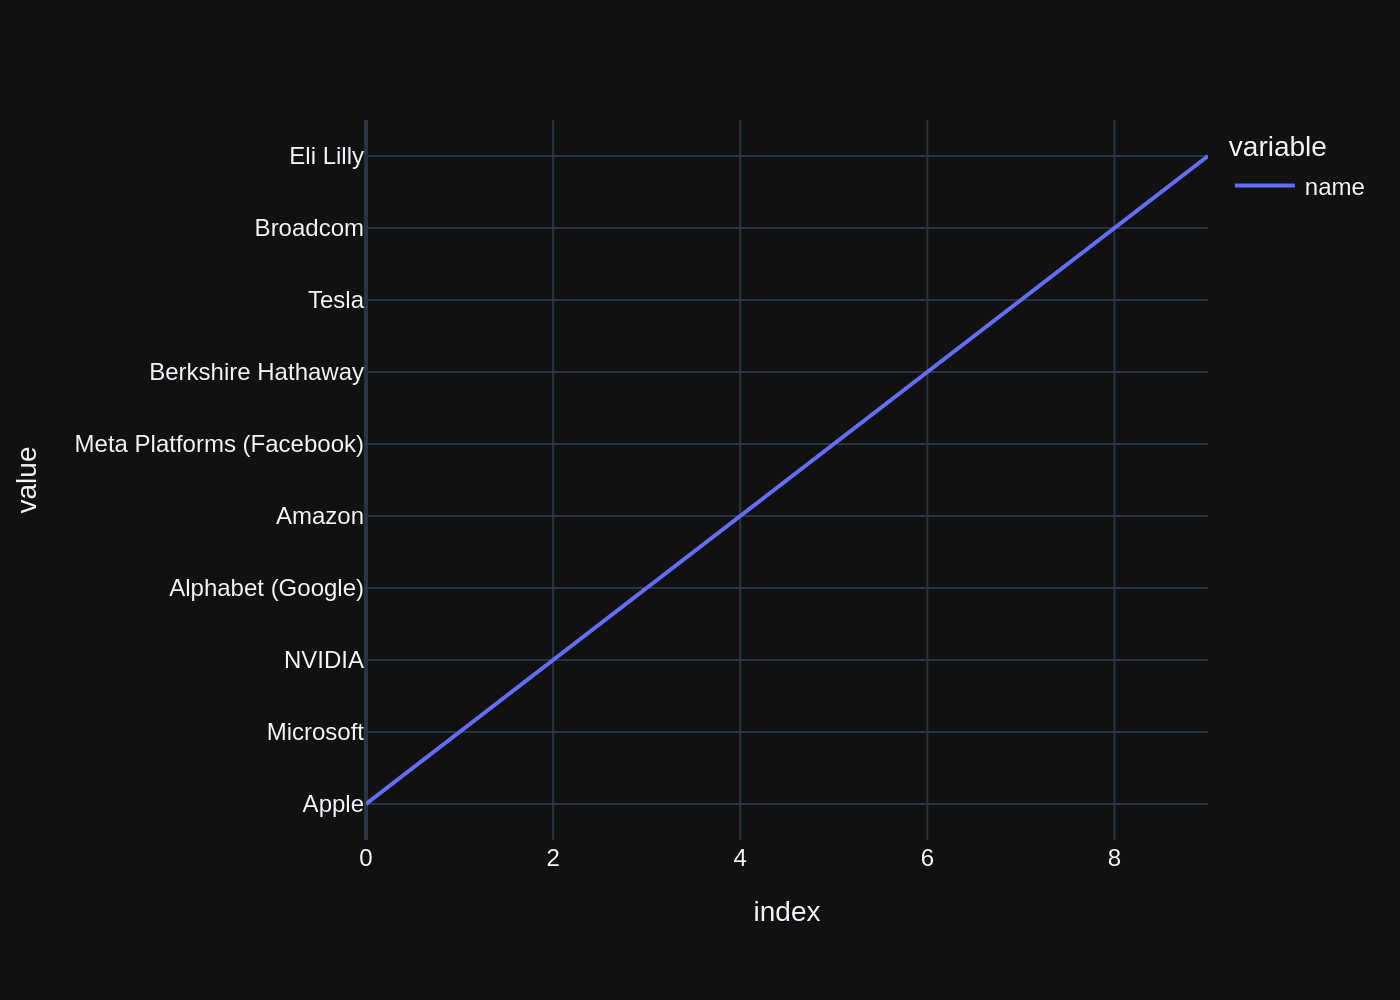

In [20]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)

In [22]:
question = """
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: Asia is region name, you need to join t_p_e_ratio table with t_country_region table on country to answer this question  
"""
resp = vn.ask_adaptive(question=question)

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION :  
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: Asia is region name, you need to join t_p_e_ratio table with t_country_region table on country to answer this question  



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER

SELECT e.name, e.pe_ratio_ttm 
FROM t_p_e_ratio AS e
JOIN t_country_region AS c ON e.country = c.code_3
WHERE c.region = 'Asia' AND e.pe_ratio_ttm > 40
ORDER BY e.pe_ratio_ttm DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm


AskResult(sql="SELECT e.name, e.pe_ratio_ttm \nFROM t_p_e_ratio AS e\nJOIN t_country_region AS c ON e.country = c.code_3\nWHERE c.region = 'Asia' AND e.pe_ratio_ttm > 40\nORDER BY e.pe_ratio_ttm DESC\nLIMIT 5", df=None, fig=None, err_msg='[ERROR] Invalid dataframe')

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1




# QUESTION :  
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,



[( SQL PROMPT )]
[{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "dividend_yield_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\

SELECT name, pe_ratio_ttm AS "PE Ratio"
FROM t_p_e_ratio
WHERE pe_ratio_ttm BETWEEN 20 AND 30
ORDER BY pe_ratio_ttm ASC
LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,PE Ratio
0,Fresenius,20.0133
1,Equatorial Energia,20.0178
2,Viper Energy Partners,20.0268
3,Avanza Bank,20.0304
4,Select Energy Services,20.0370



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

fig = go.Figure()

if len(df) == 1:
    fig.add_trace(go.Indicator(
        mode="number",
        value=df['PE Ratio'].values[0],
        title={"text": df['name'].values[0]},
        domain={'row': 0, 'column': 0}
    ))
else:
    fig.add_trace(go.Bar(
        x=df['name'],
        y=df['PE Ratio'],
        marker_color='rgb(158,202,225)',
        name='PE Ratios'
    ))

fig.update_layout(title='Top 5 Companies with Lowest PE Ratio in Range 20-30',
                  plot_bgcolor='white',
                  xaxis=dict(tickangle=-45),
                  yaxis=dict(gridcolor='lightgray'))

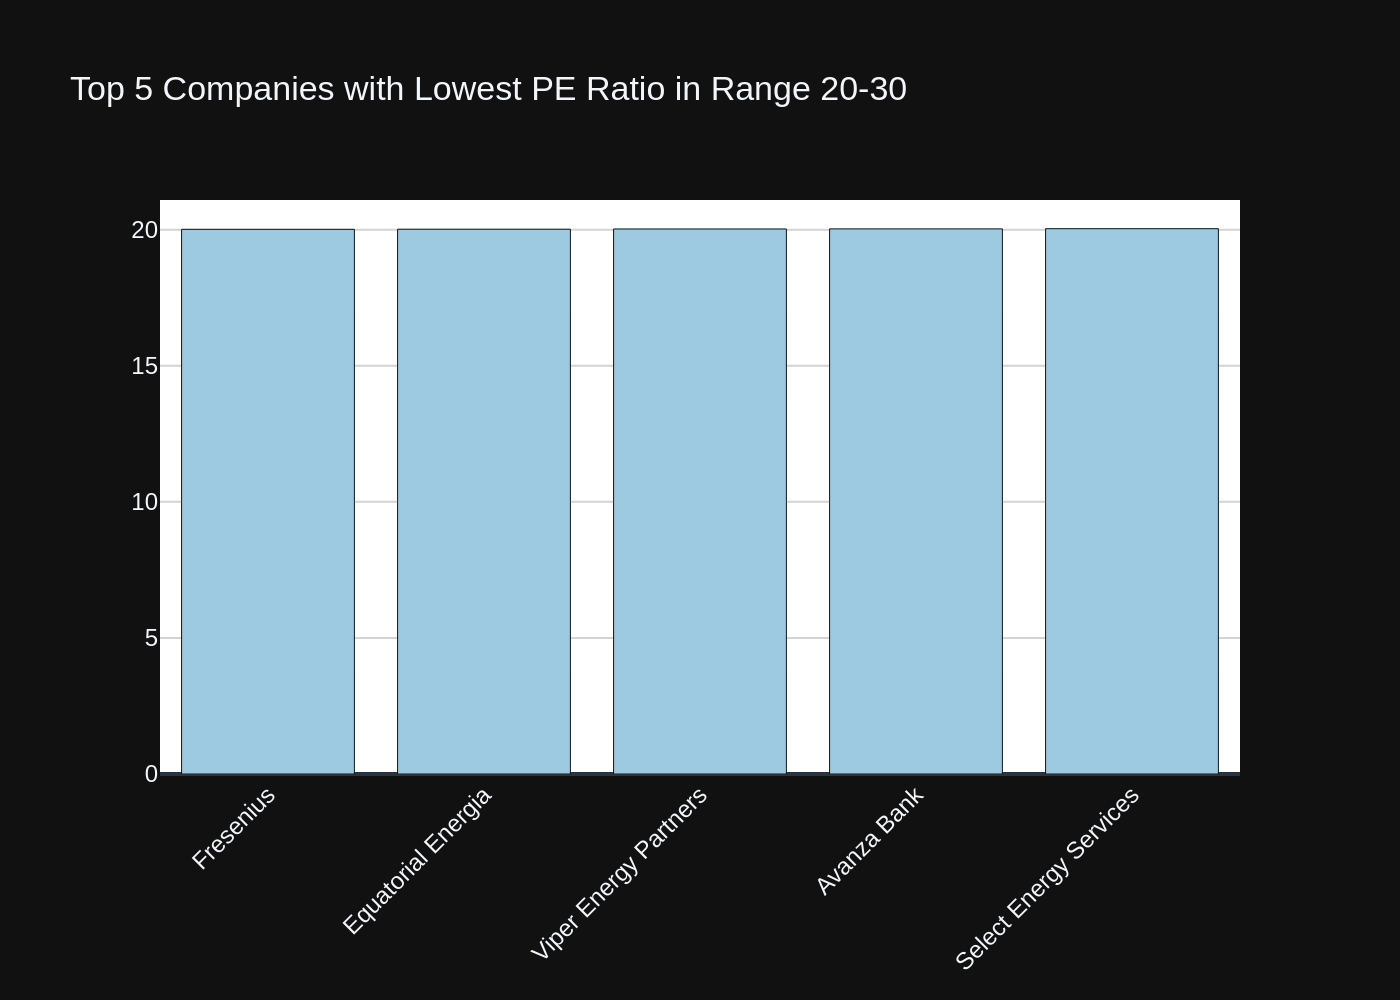

AskResult(sql='SELECT name, pe_ratio_ttm AS "PE Ratio"\nFROM t_p_e_ratio\nWHERE pe_ratio_ttm BETWEEN 20 AND 30\nORDER BY pe_ratio_ttm ASC\nLIMIT 5', df=                     name  PE Ratio
0               Fresenius   20.0133
1      Equatorial Energia   20.0178
2   Viper Energy Partners   20.0268
3             Avanza Bank   20.0304
4  Select Energy Services   20.0370, fig=Figure({
    'data': [{'marker': {'color': 'rgb(158,202,225)'},
              'name': 'PE Ratios',
              'type': 'bar',
              'x': array(['Fresenius', 'Equatorial Energia', 'Viper Energy Partners',
                          'Avanza Bank', 'Select Energy Services'], dtype=object),
              'y': array([20.0133, 20.0178, 20.0268, 20.0304, 20.037 ])}],
    'layout': {'plot_bgcolor': 'white',
               'template': '...',
               'title': {'text': 'Top 5 Companies with Lowest PE Ratio in Range 20-30'},
               'xaxis': {'tickangle': -45},
               'yaxis': {'gridcolor': 'lightgray

In [23]:
question = """
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,
"""
resp = vn.ask_adaptive(question=question)

### Check completion time

In [21]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"Completed tests:\n================\n run on host '{hostname}' \n with LLM model '{model_name}' \n took {elapsed_time:.2f} sec")

Completed tests:
 run on host 'papa-game' 
 with LLM model 'deepseek-coder-v2' 
 took 1222.36 sec
